In [1]:
import os
print(os.getcwd())

c:\Users\tomje\OneDrive - Cardiff University\Documents\PHD\CODE\Acoustic-Emission


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import src
from testingUtils import testing_main as tm
import matplotlib.pyplot as plt
import numpy as np


import src
# import matplotlib as mp
# mpl.use('TkAgg')
%matplotlib inline

# Testing Main Notebook

`testing_main.py` contains multiple functions:
- `main()`: choose an exp to load in, update and save it.
- `update(exp)`: update exp with new data, and display nc4.
- `check_ae(exp)`: plot last file of AE data in test.
- `check_nc4(exp)`: calc last NC4 file attributes and plot results.

No existing exp file selected!
----------------------TESTING EXP FILE----------------------
Test No: 16
Date: 2024-07-03
Data: ..\..\AE\Testing\24_07_03_weartest_D1.3_#1000
No. Files: AE-141 NC4-142
------------------------------------------------------------
------------------------------------------------------------
NC4 - File 141:
	Mean radius = 0.625682 mm
	Runout = 4.911 um
	Wear = -6.385 %
------------------------------------------------------------


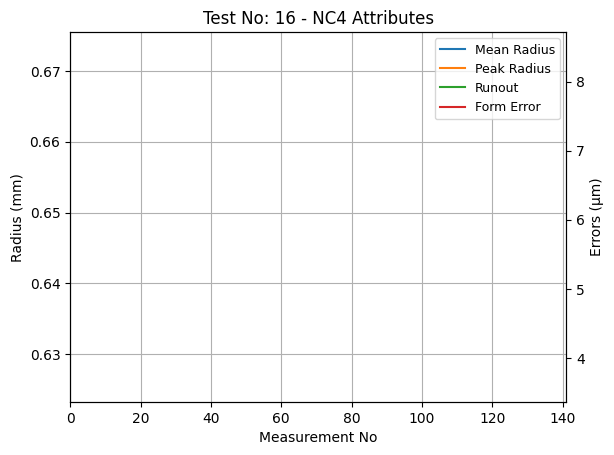

In [4]:
exp = tm.main()

------------------------------------------------------------
NC4 - File 141:
	Mean radius = 0.625682 mm
	Runout = 4.911 um
	Wear = -6.385 %
------------------------------------------------------------


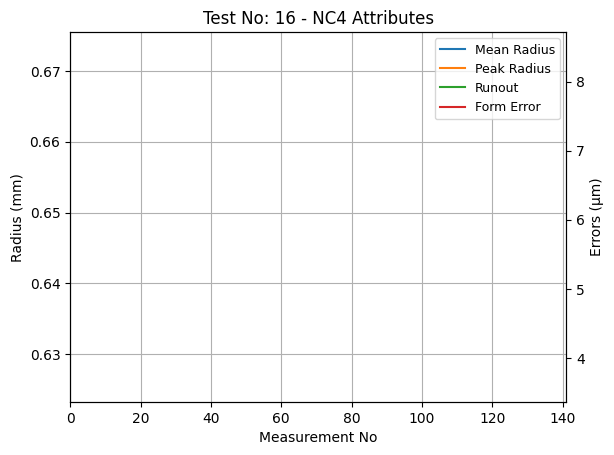

In [5]:
f = tm.update(exp)

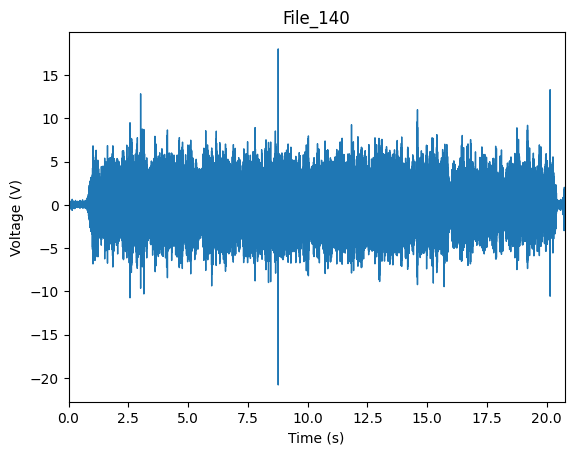

In [6]:
tm.check_ae(exp)

In [15]:
exp.nc4.process()

NC4- Calc att: 100%|██████████| 142/142 [00:08<00:00, 17.09it/s]


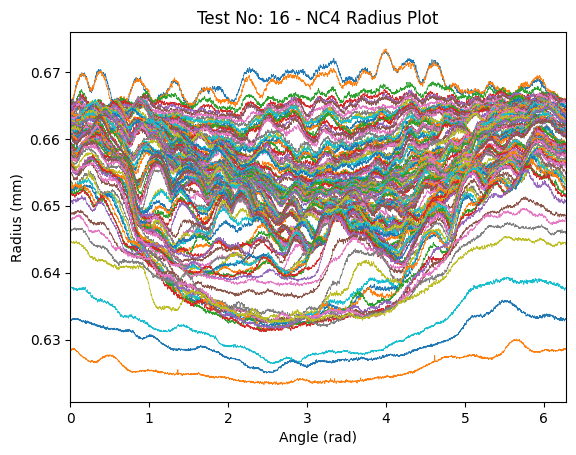

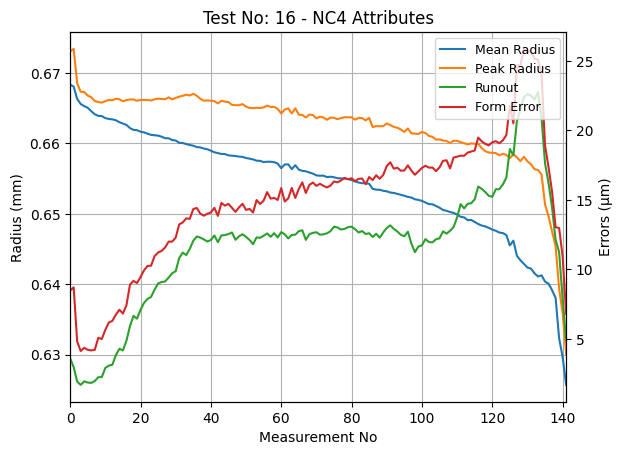

In [5]:
f = exp.nc4.plot_xy()
f = exp.nc4.plot_att()

(<Figure size 640x480 with 2 Axes>,
 <AxesSubplot: title={'center': 'Test No: 16 - NC4 Radius Surface'}, xlabel='Angle (rad)', ylabel='Measurement Number'>)

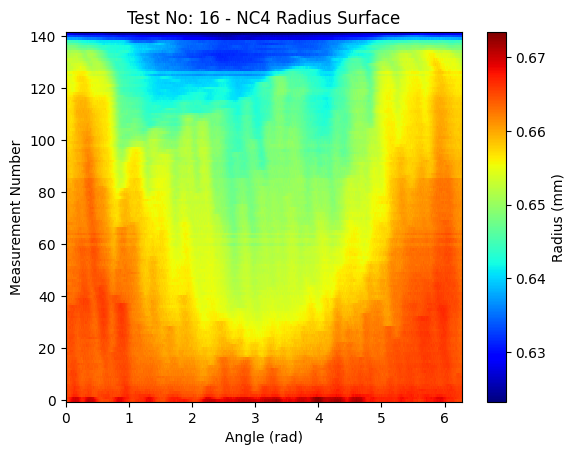

In [6]:
exp.nc4.plot_surf()

In [4]:
exp.save()

### Extra Processing - Wait till CUSP

In [7]:
exp.ae.process()

Calc FFT 1 kHz: 100%|██████████| 141/141 [01:26<00:00,  1.64it/s]


In [8]:
exp.create_feat_df()

Feature DF of Test 16:
        RMS   Kurtosis  Amplitude  Skewness  Freq 10 kHz  Freq 35 kHz  \
0  0.083683  14.596388   2.308359  0.079092    31.705837    40.138229   
1  0.766194  10.057939   8.947037 -0.088730    34.296551    63.641849   
2  0.894381   5.102658   7.919537 -0.047692    33.032603    66.162840   
3  1.024386   4.950631   7.783612 -0.078962    33.252501    69.442022   
4  1.164607   4.695296   9.777631 -0.089323    33.801860    70.756917   

   Freq 134 kHz  Mean radius  Peak radius  Radius diff    Runout  Form error  
0     26.967378     0.668085     0.673435    -0.000273  0.002976    0.008709  
1     48.775924     0.666326     0.668546    -0.001759  0.001932    0.004809  
2     52.003068     0.665606     0.667348    -0.000720  0.001693    0.004128  
3     52.845859     0.665303     0.667317    -0.000303  0.001954    0.004363  
4     53.699006     0.665069     0.666813    -0.000234  0.001865    0.004216  


,RMS,Kurtosis,Amplitude,Skewness,Freq 10 kHz,Freq 35 kHz,Freq 134 kHz,Mean radius,Peak radius,Radius diff,Runout,Form error
0,0.083683,14.596388,2.308359,0.079092,31.705837,40.138229,26.967378,0.668085,0.673435,-0.000273,0.002976,0.008709
1,0.766194,10.057939,8.947037,-0.088730,34.296551,63.641849,48.775924,0.666326,0.668546,-0.001759,0.001932,0.004809
2,0.894381,5.102658,7.919537,-0.047692,33.032603,66.162840,52.003068,0.665606,0.667348,-0.000720,0.001693,0.004128
3,1.024386,4.950631,7.783612,-0.078962,33.252501,69.442022,52.845859,0.665303,0.667317,-0.000303,0.001954,0.004363
4,1.164607,4.695296,9.777631,-0.089323,33.801860,70.756917,53.699006,0.665069,0.666813,-0.000234,0.001865,0.004216
...,...,...,...,...,...,...,...,...,...,...,...,...
136,1.069080,4.441504,13.896628,0.000905,44.896452,67.387141,47.715962,0.639147,0.647486,-0.000918,0.014447,0.015578
137,1.060228,4.119002,11.067955,-0.000861,45.076170,65.490337,47.519646,0.638054,0.645422,-0.001093,0.012126,0.013039
138,1.020928,4.273238,12.176637,0.006736,45.958043,64.908474,46.601269,0.632316,0.639360,-0.005738,0.011246,0.012972
139,0.996990,4.828225,10.779754,-0.002016,44.611794,63.311744,45.355057,0.629630,0.635903,-0.002686,0.007893,0.010938


In [9]:
exp.save()

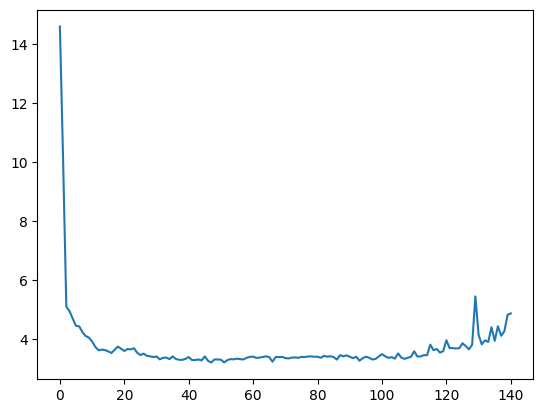

In [14]:
plt.plot(exp.features['Kurtosis'])

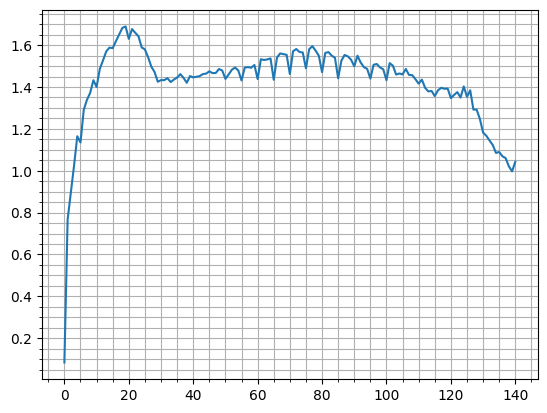

In [13]:
plt.plot(exp.features['RMS'])
plt.minorticks_on()
plt.grid(True, which='both')

In [15]:
nc4_df = exp.features.loc[:, ['Mean radius', 'Peak radius', 'Runout', 'Form error']]
nc4_df.head()
nc4_df.to_csv(fr'{exp.dataloc}\NC4Data.csv')